<a href="https://colab.research.google.com/github/idnm/cpflow/blob/master/CPFlow_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
try:
   from qiskit.transpiler.passes import SolovayKitaevDecomposition
except ImportError:
  # Install Rust compiler, needed to build wheel for qiskit-terra
  !apt install rustc
  !gdown --id 1PULtTc-2e9z4bswh_SQqL5oy_4JpfV7c
  !chmod +x evcxr_jupyter
  !./evcxr_jupyter --install
  # Install qiskit branch with SolovayKitaevDecomposition
  !pip install git+https://github.com/LNoorl/qiskit-terra@d2e0dc1185ccc3b0c9957e3d7d9bc610dede29d4

try:
   import cpflow
except ImportError:
  !pip install cpflow

from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
import numpy as np

from jax import vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt

from cpflow import *

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cargo libstd-rust-1.57 libstd-rust-dev
Suggested packages:
  cargo-doc lld-13 clang-13
Recommended packages:
  llvm-13
The following NEW packages will be installed:
  cargo libstd-rust-1.57 libstd-rust-dev rustc
0 upgraded, 4 newly installed, 0 to remove and 39 not upgraded.
Need to get 78.4 MB of archives.
After this operation, 350 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libstd-rust-1.57 amd64 1.57.0+dfsg1+llvm-0ubuntu1~18.04.1 [38.7 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libstd-rust-dev amd64 1.57.0+dfsg1+llvm-0ubuntu1~18.04.1 [32.9 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 rustc amd64 1.57.0+dfsg1+llvm-0ubuntu1~18.04.1 [3,415 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 car

# Background


The main goal of CPFlow is to find quantum circuits consisting of CNOT+arbitrary 1q gates that simultaneously
- minimize a given loss function $L(U)$
- do it with as few CNOT gates as possible

Indirectly the circuits can also be optimized for CNOT depth and even T count or T depth in some cases.

CPFlow uses CP templates to combine the architecture search and parameter optimization into a single coherent continuous optimization. Example of a CP template is shown below.

 (_NOTE: code in this section is for illustration purposes, actual usage examples are found in later sections_.)

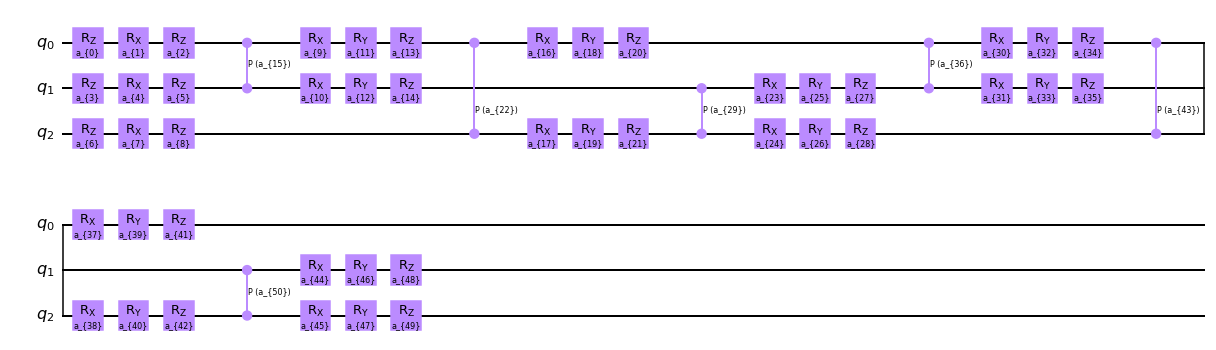

In [ ]:
from cpflow.topology import connected_layer, fill_layers

num_qubits = 3
num_cp_gates = 6
cp_template = Ansatz(num_qubits, 'cp', fill_layers(connected_layer(num_qubits), num_cp_gates))
cp_template.circuit().draw(output='mpl')

Controlled phase gates CP($a$) with $a=0$ are equivalent to identity gates, with $a=\pi$ to CZ gates. CP($a$) with intermediate values of $a$ can be decomposed using 2 CZ gates. Hence, different choices of CP angles in a CP template corresponds to different architectures of a standard CZ/CNOT circuits. To minimize CZ count minimization of the original loss function is performed with a regularization term
$$\mathcal{L}(U)=L(U)+r \sum_{a_i\in CP}R(a_i)$$
Here $U$ is the unitary matrix of the CP template, $L(U)$ is the original loss function, $r$ is the overall weight of the regularization term. The sum is over all CP angles, penalty function $R(a)$ for a single angles has the following shape:

Text(0.5, 0, 'Angle of CP gate $a$')

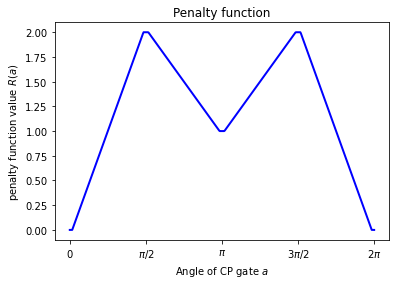

In [ ]:
from cpflow.cp_utils import make_regularization_function
from cpflow.main import RegularizationOptions

penalty_func = make_regularization_function(RegularizationOptions)
a_sweep = jnp.linspace(0, 2*jnp.pi, 500)
plt.plot(a_sweep, vmap(penalty_func)(a_sweep), 'blue', linewidth=2)
plt.xticks([0, jnp.pi/2, jnp.pi, 3*jnp.pi/2, 2*jnp.pi], ['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.title('Penalty function')
plt.ylabel('penalty function value $R(a)$')
plt.xlabel('Angle of CP gate $a$')

Both the regularization term and the original loss function typically have many local minumums. CPFlow takes a straightfoward approach of extensive multi-start optimization to mitigate the problem. There are two basic synthesis routines
- Static: optimization with a fixed CP template and regularization weight $r$.
- Adaptive: series of static optimizations with hyperparameters (number of CP gates and value of $r$) tuned by the [Hyperopt algorithm](http://hyperopt.github.io/hyperopt/) .


The rest of the notebook containes several examples of using both routines as well as some additional features.

# Static synthesis example: 3q Toffoli gate

## Defining the target unitary


We will now use CPFlow to find efficient decomposisions of the Toffoli 3 gate. One can input the unitary matrix directly, but we will import it from `qiskit`


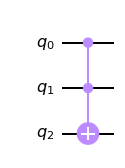

In [ ]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data
qc.draw(output='mpl')

Note that CPFlow does not follow the little-endian convention of `qiskit` so we applied the `reverse_bits()` method before extracting the unitary. 

## Setting up the decomposer

The following lines initialize the decomposer.

In [ ]:
layer = [[0, 1], [1, 2]]  # Layer corresponding to the linearly connected qubit topology 0-1-2.
decomposer = Synthesize(layer, target_unitary=u_toff3, label='toff3_chain')
options = StaticOptions(
    num_cp_gates=12, 
    r=0.0005,
    accepted_num_cz_gates=10,
    num_samples=5,
    )

- The main role of `layer` is to provide information about qubit connectivity -- the final decompositions can only contain entangling gates between qubit pairs specified in `layer`.  The order of qubits in each pair does not matter, the order of pair and presence of duplicated might matters in theory but apparently not in practice. The simple way to construct layers is to just list (in arbitrary order) all pairs of qubits that admit entangling gates.
- `label` is just a name to keep track of what we are decomposing (referencing the unitary matrix itself is often not helpful). It is also used to name the file on a disk that stores the results of the synthesis.
- `options` specify exact details of template construction, optimization and verification. The only required attributes are `num_cp_gates` -- total number of entagling gate in the template (together with `layer` this specifies the template completely) and `accepted_num_cz_gates` -- only decompositions with CZ count below this value will be verified and stored. Additionaly, we provided the value of the regularization weight (same as default, just to emphasize it is there) and chose a relatively small number of samples for multistart optimization `num_samples` which is sufficient in this case.

## Running the decomposer



We can now run the decomposer.

In [ ]:
results = decomposer.static(options)


Starting decomposition routine with the following options:

 StaticOptions(num_samples=5, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=0, rotation_gates='xyz', num_cp_gates=12, r=0.0005, accepted_num_cz_gates=10)

Computing raw results...

Selecting prospective results...

Found 5. Verifying...


  0%|          | 0/5 [00:00<?, ?it/s]


5 successful. cz counts are:
[8, 8, 9, 9, 9]


## Analyzing decompositions

Five decompositions with CZ count below the specified were found. They are stored in `decompositoins` attribute of `results`.

In [ ]:
results.decompositions

[< toff3_chain| Approximate | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  >,
 < toff3_chain| Approximate | loss: 0.0  | CZ count: 8 | CZ depth: 8  >,
 < toff3_chain| Approximate | loss: 3.5762786865234375e-07  | CZ count: 9 | CZ depth: 9  >,
 < toff3_chain| Approximate | loss: 0.0  | CZ count: 9 | CZ depth: 9  >,
 < toff3_chain| Approximate | loss: 0.0  | CZ count: 9 | CZ depth: 9  >]

Let us take a closer look at the first decomposition.

< toff3_chain| Approximate | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  >


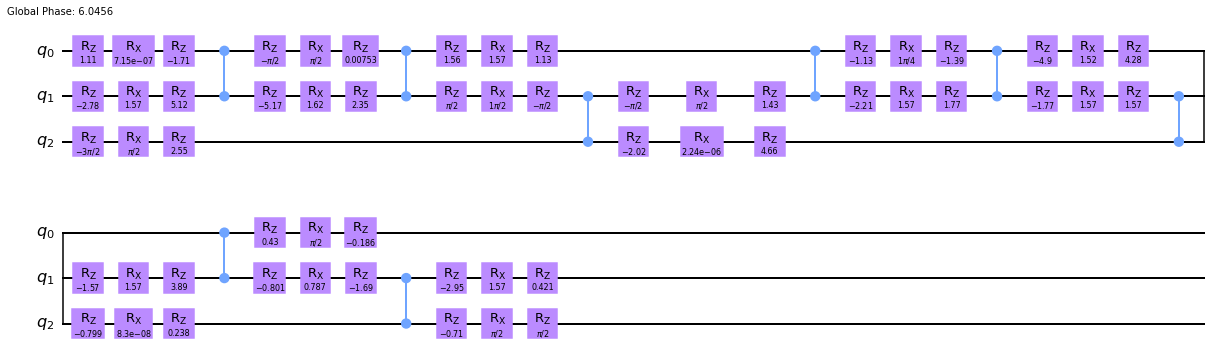

In [ ]:
d = results.decompositions[0]
print(d)
d.circuit.draw(output='mpl')

We can see explicitly that it complies with the linear connectivity and has 8 CZ gates. The `loss` value here is the Hilbert-Schmidt distance to the target unitary and is basically within machine precision. `Approximate` means that the decomposition is a result of straightforward numerical optimization. Looking at the angles in the circuit it is tempting to simplify/remove some of them. CPFlow has an experimental automated routine to do this.

In [ ]:
d.refine()

'Refined to Clifford+T'

In this case the routine was able to find an exact version of the circuit and decompose it into a Clifford+T basis. This is reflected in a new description of the circuit which now also features T count and T depth. This can also be checked by looking at the new circuit diagram (rotation gates with angles $\pi/4$ are non-clifford).

< toff3_chain| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >


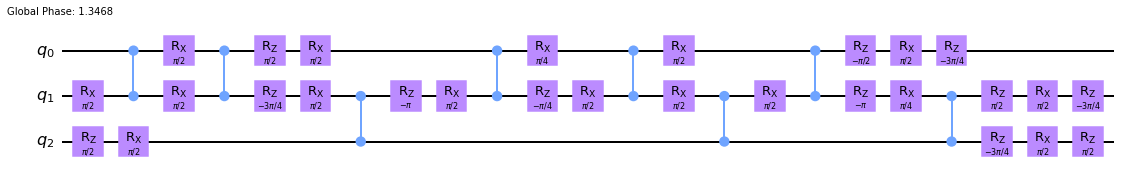

In [ ]:
print(d)
d.circuit.draw(output='mpl')

## Saving and loading results

The results are __automatically__ saved if you prodived a label with your decomposition. The default location is `results/label` but it can be ovewritten by providing `save_to` path in the decomposer call `decomposer.static(options, save_to=path)`. Note: if you've applied `refine` method to some of the decompositions the refined results are not saved by default. To save you can 

In [ ]:
results.save()

Existing results can be loaded as follows.

In [ ]:
del results
results = Results.load('results/toff3_chain')
results.decompositions

[< toff3_chain| Approximate | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  >,
 < toff3_chain| Approximate | loss: 0.0  | CZ count: 8 | CZ depth: 8  >,
 < toff3_chain| Approximate | loss: 3.5762786865234375e-07  | CZ count: 9 | CZ depth: 9  >,
 < toff3_chain| Approximate | loss: 0.0  | CZ count: 9 | CZ depth: 9  >,
 < toff3_chain| Approximate | loss: 0.0  | CZ count: 9 | CZ depth: 9  >]

# Adaptive synthesis example: decomposition of 4q Toffoli gate

## Hyperparameters

The static routine that we used above has several hyperparameters that can significantly alter the results. Two of the most crucial appear to be the number of gates in a CP template and the regularization weight $r$. Adaptive routine uses Hyperopt's algorithm to tune these hyperparameters and stores interesting decompositions found along the way. We will illustrate the adaptive routine with the 4q Toffoli gate on a 'star'-shaped topology. 

## Defining the target unitary

Again, we will define the target unitary using `qiskit`.

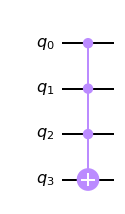

In [ ]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data
qc.draw(output='mpl')

## Setting up the decomposer

Decomposer is set up in a very similar manner to the static case, except that now options must be an instance of the `AdaptiveOptions` class.

In [ ]:
layer = [[0, 1], [0, 2], [0, 3]]  # 'Star' or 'T-shaped' layer where qubits 1,2,3 are only connected to qubit 0.
decomposer = Synthesize(layer, target_unitary=u_toff4, label='toff4_star')
options = AdaptiveOptions(
    min_num_cp_gates=10,
    max_num_cp_gates=30,
    r_mean=0.0005,  # Default value, speficied explicitly only for illustration.
    r_variance=0.5,  # Default value, speficied explicitly only for illustration.
    num_samples=500,
    max_evals=5
)

Here `layer` again is intended to indicate the qubit connectivity. Adaptive options have only two required attributes: `min_num_cp_gates` and `max_num_cp_gates` specifying the allowed range for CP templates during the hyperparameter tuning. The second hyperparameter that is optimized is the regularization weight $r$ sampled from the lognormal distribution with mean `r_mean` and variance `r_variance`. We have explicitly set these parameters to their default values to emphasize that they are present. `num_samples` determines how many initial conditions are used for multi-start optimization at each hyperparmeter configuration. `max_evals` determines the total number of hyperparameter evaluations.

## Running the decomposer

Now that the setup is in place we can run the decomposer.

In [ ]:
results = decomposer.adaptive(options)


Starting decomposition routine with the following options:

 AdaptiveOptions(num_samples=500, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=0, rotation_gates='xyz', min_num_cp_gates=10, max_num_cp_gates=30, r_mean=0.0005, r_variance=0.5, max_evals=5, target_num_cz_gates=0, stop_if_target_reached=False, keep_logs=False)


Evaluations:   0%|          | 0/5 [00:00<?, ?it/s]


------------------------------------------
iteration 0/5

num_cp_gates: 18, r: 0.0005069511389752133
score: inf, cz counts of prospective results: []

Found no decompositions potentially improving the current best count 61.

------------------------------------------
iteration 1/5

num_cp_gates: 18, r: 0.00042233662661280336
score: inf, cz counts of prospective results: []

Found no decompositions potentially improving the current best count 61.

------------------------------------------
iteration 2/5

num_cp_gates: 18, r: 0.0005889875866486171
score: inf, cz counts of prospective results: []

Found no decompositions potentially improving the current best count 61.

------------------------------------------
iteration 3/5

num_cp_gates: 11, r: 0.0019248510669024055
score: inf, cz counts of prospective results: []

Found no decompositions potentially improving the current best count 61.

------------------------------------------
iteration 4/5

num_cp_gates: 27, r: 0.00088169516980888

So, in the first few iteration the adaptive routine found a decomposition with 18 gates. Let us take a look at it.

< toff4_star| Approximate | loss: 0.0  | CZ count: 18 | CZ depth: 18  >


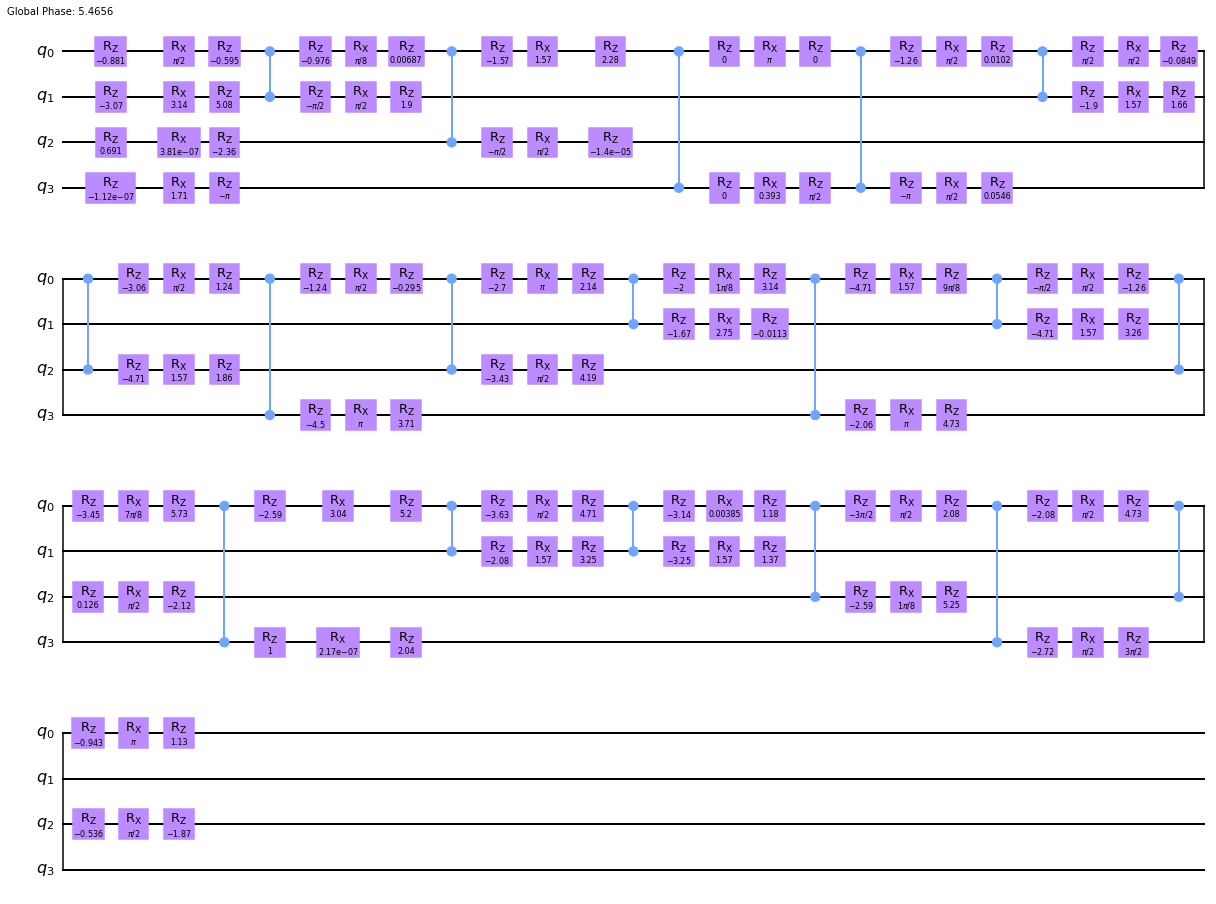

In [5]:
d = results.decompositions[-1]
print(d)
d.circuit.draw(output='mpl')

We can see explicitly from the circuit that it complies with the topological restrictions (all two-qubit gates start at qubit 0). The best decomposition of the 4q Toffoli gate on the star topology has 16 CZ gates. To keep searching for better results we can just change the number of `max_evals` and run the synthesis again. The existing evaluations are automatically taken into account and the process continues with the next evaluation.

_(NOTE: first 20 hyperparameter evaluations are random and inteded to sample broadly from the search space. Actual optimization starts after that. If `num_samples` is sifficiently large to accurately evaluate the quality of hyperparameters (which is a stochastic function) convergence could be expected near about 100 evaluations. However, near-optimal or optimal decompositions are likely to be found much earlier. As we saw, a near-optimal 18 CZ decomposition was found during the first 5 evaluations)_

In [ ]:
options.max_evals = 20
results = decomposer.adaptive(options)


Starting decomposition routine with the following options:

 AdaptiveOptions(num_samples=500, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=0, rotation_gates='xyz', min_num_cp_gates=10, max_num_cp_gates=30, r_mean=0.0005, r_variance=0.5, max_evals=20, target_num_cz_gates=0, stop_if_target_reached=False, keep_logs=False)

Found existing trials, resuming from here.


Evaluations:   0%|          | 0/15 [00:00<?, ?it/s]


------------------------------------------
iteration 5/20

num_cp_gates: 25, r: 0.0011866360100009831
score: 25.387413024902344, cz counts of prospective results: [18, 18, 20, 20, 21, 21, 22, 22, 22, 23, 25, 25, 27]

Found no decompositions potentially improving the current best count 18.

------------------------------------------
iteration 6/20

num_cp_gates: 21, r: 0.0008162760956025106
score: 29.965784072875977, cz counts of prospective results: [22, 22]

Found no decompositions potentially improving the current best count 18.

------------------------------------------
iteration 7/20

num_cp_gates: 22, r: 0.0003687679260635769
score: 29.71785545349121, cz counts of prospective results: [21, 24, 25]

Found no decompositions potentially improving the current best count 18.

------------------------------------------
iteration 8/20

num_cp_gates: 16, r: 0.0008425086752551032
score: inf, cz counts of prospective results: []

Found no decompositions potentially improving the current b

# Using custom loss functions: state preparation and relative phase Toffoli gate

# Extra features

## Optimizing CZ depth or other metrics

## Reproducibility

## Tweaking templates